In [39]:
import numpy as np
import pandas as pd
import os
import pymc3 as pm
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from theano import shared
import theano.tensor as tt
from operator import mul
from itertools import accumulate
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
mpl.style.use("ggplot")
warnings.filterwarnings("ignore")
os.chdir(r"C:\Users\admin\Desktop\Machine learning\Deep learning\crypto_data")

In [2]:
df_eth = pd.read_csv("ETH-USD.csv",header=None)
df_goog = pd.read_csv(r"C:\Users\admin\Documents\Projet FUI RiD\Python Finance tutorial\stock_dfs\GOOG.csv")
df_goog.head()

,Symbol,Date,Close,High,Low,Open,Volume
0,GOOG,2014-03-27,556.9312,566.4451,551.4064,566.4451,13087
1,GOOG,2014-03-28,558.4570,564.8794,557.1406,559.7136,41115
2,GOOG,2014-03-31,555.4453,565.4478,555.4054,565.3381,10801
3,GOOG,2014-04-01,565.6074,566.8939,557.1805,557.1805,7953
4,GOOG,2014-04-02,565.4478,603.1743,560.6510,579.1702,147099


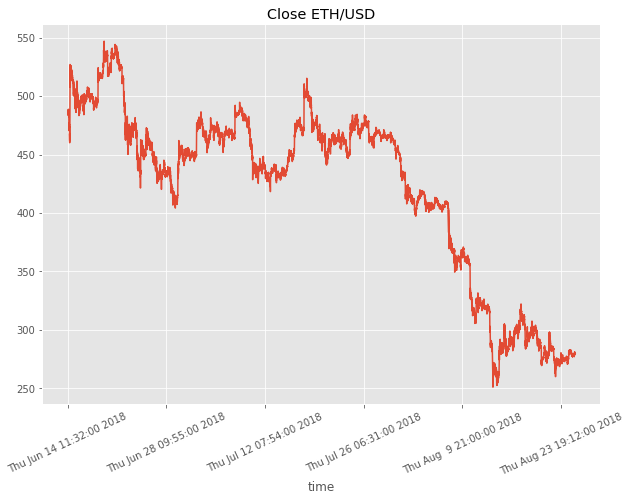

In [8]:
eth_df_close = df_eth[[0,4]]
eth_df_close.columns = ["time","Close"]
eth_df_close["time"] = eth_df_close["time"].map(lambda x: time.ctime(x))
eth_df_close.set_index("time")["Close"].plot(title="Close ETH/USD",figsize=(10,7))
plt.xticks(rotation=25)
plt.show()

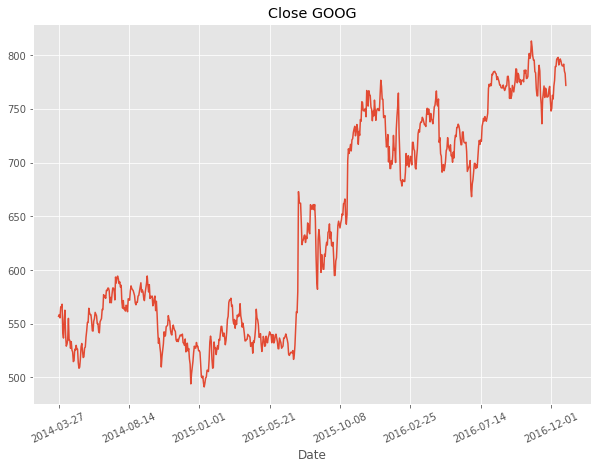

In [9]:
df_goog.set_index("Date")["Close"].plot(title="Close GOOG",figsize=(10,7))
plt.xticks(rotation=25)
plt.show()

## Prediction de la tendance du cours avec lissage prealable

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

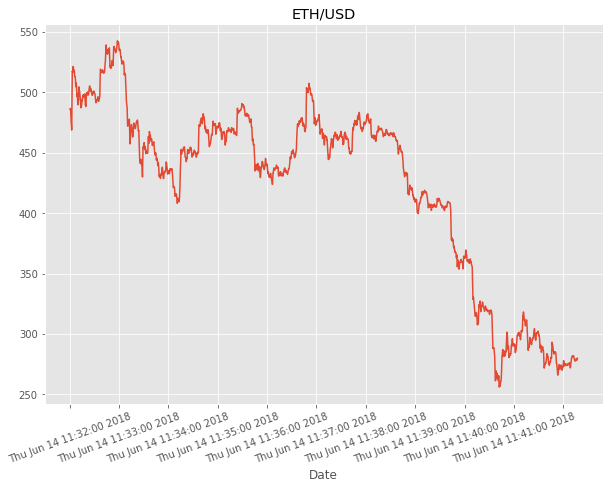

In [11]:
smooth_df = eth_df_close['Close'].rolling(100).mean().dropna()
fig, ax = plt.subplots(figsize=(10,7))

ax.set_xticks(np.arange(0, len(eth_df_close), 10000))
ax.set_xticklabels(eth_df_close['time'][:10], rotation=20)
ax.plot(smooth_df)
ax.set_title("ETH/USD")
ax.set_xlabel("Date")
plt.show()

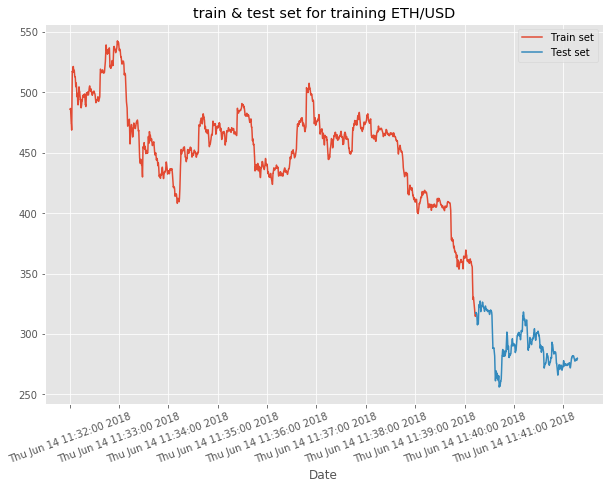

In [12]:
fig
train = smooth_df[:int(len(smooth_df)*0.8)]
test = smooth_df[int(len(smooth_df)*0.8):]
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(train, label="Train set")
ax.plot(test, label="Test set")
ax.set_xlabel("Date")
ax.set_xticks(np.arange(0, len(eth_df_close), 10000))
ax.set_xticklabels(eth_df_close['time'][:10], rotation=20)
plt.title("train & test set for training ETH/USD")
plt.legend()
plt.show()

In [13]:
observed_shared = shared(train.values)
train_shared = shared(train.shape[0])
test_shared = shared(test.shape[0])
int(tt.cast(train_shared,'int64').eval()), int(tt.cast(test_shared,'int64').eval()), int(tt.cast(train_shared,'int64').eval())+int(tt.cast(test_shared,'int64').eval())

(82185, 20547, 102732)

In [14]:
ts_model_smooth = pm.Model()
with ts_model_smooth:
    sd = pm.HalfNormal('sd', sd=.5)
    mu = pm.Normal('mu', mu=0, sigma=1.)
    z = pm.GaussianRandomWalk("z",mu=mu, sd=sd, observed=observed_shared)

In [15]:
with ts_model_smooth:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd]
Sampling 2 chains, 0 divergences: 100%|█| 5000/5000 [00:25<00:00, 192.39draws/s
The acceptance probability does not match the target. It is 0.9008155254704543, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886530451818591, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
#On met notre donnee de test dans les observations
test_observed = np.empty((test.shape[0],))
observed_shared.set_value(test_observed)

In [17]:
with ts_model_smooth:
    ppc_test = pm.sample_posterior_predictive(trace,samples=2000)
ppc_test['z'].shape

100%|██████████████████████████████████████| 2000/2000 [00:38<00:00, 51.85it/s]


(2000, 20547)

In [18]:
train.shape, test.shape, smooth_df.shape

((82185,), (20547,), (102732,))

In [19]:
low,high = np.percentile(ppc_test['z'], [2.5,97.5], axis=0)

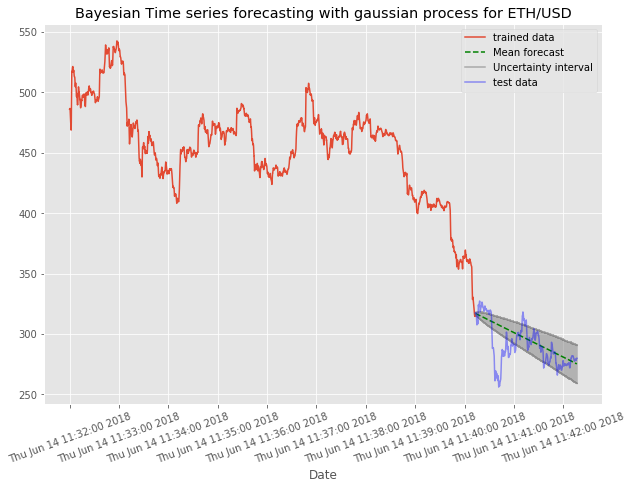

In [20]:
test_set_plot_arr = np.empty(smooth_df.shape)
test_set_plot_arr[:] = np.nan
test_set_plot_arr[-len(test):] = test.values

fig, ax = plt.subplots(figsize=(10,7))
empty_arr_bis = np.empty((train.values.shape[0],))
empty_arr_bis[:] = np.nan
empty_arr = np.empty((low.shape[0],))
empty_arr[:] = np.nan

train_arr = np.r_[train.values,empty_arr]
ax.plot(train_arr,label="trained data")
ax.plot(np.r_[empty_arr_bis, ppc_test['z'].mean(axis=0) + train.values[-1]],label="Mean forecast", c='green', ls="--")
ax.plot(np.r_[empty_arr_bis, low + train.values[-1]],c="grey", label="Uncertainty interval", alpha=0.6)
ax.plot(np.r_[empty_arr_bis, high + train.values[-1]], c="grey", alpha=0.6)
ax.fill_between(np.linspace(train.shape[0], train.shape[0] + test.shape[0], test.shape[0]), high + train.values[-1], low + train.values[-1], color="grey", alpha=0.5)
ax.plot(test_set_plot_arr,label="test data",alpha=0.4,c="b")

ax.set_xticks(np.arange(0, len(eth_df_close), 10000))
ax.set_xticklabels(eth_df_close['time'], rotation=20)
ax.set_xlabel("Date")
plt.legend()
plt.title("Bayesian Time series forecasting with gaussian process for ETH/USD")
ax = plt.gca()
plt.show()

## Application a un cours d'action GOOG de 2014 a 2016

In [21]:
df_goog.set_index('Date',inplace=True)

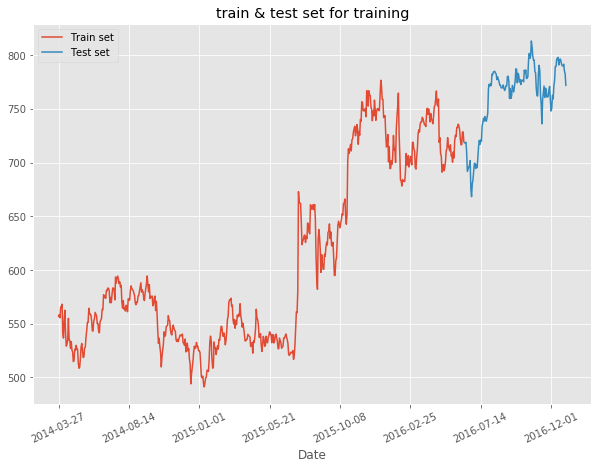

In [22]:
train = df_goog['Close'][:int(len(df_goog)*0.8)]
test = df_goog['Close'][int(len(df_goog)*0.8):]
plt.figure(figsize=(10,7))
plt.plot(train, label="Train set")
plt.plot(test, label="Test set")
plt.xticks(df_goog.index[::100],rotation=25)
plt.xlabel("Date")
plt.title("train & test set for training")
plt.legend()
plt.show()

In [23]:
observed_shared = shared(train.values)
train_shared = shared(train.shape[0])
test_shared = shared(test.shape[0])
int(tt.cast(train_shared,'int64').eval()), int(tt.cast(test_shared,'int64').eval()), int(tt.cast(train_shared,'int64').eval())+int(tt.cast(test_shared,'int64').eval())

(577, 145, 722)

In [24]:
ts_model_goog = pm.Model()
with ts_model_goog:
    sd = pm.HalfNormal('sd', sd=.5)
    mu = pm.Normal('mu', mu=0, sigma=1.)
    z = pm.GaussianRandomWalk("z",mu=mu, sd=sd, observed=observed_shared)

In [25]:
with ts_model_goog:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd]
Sampling 2 chains, 0 divergences: 100%|█| 5000/5000 [00:07<00:00, 646.04draws/s


In [27]:
#On met notre donnee de test dans les observations
test_observed = np.empty((test.shape[0],))
observed_shared.set_value(test_observed)
train.shape, test.shape

((577,), (145,))

In [28]:
with ts_model_goog:
    ppc_test = pm.sample_posterior_predictive(trace,samples=2000)
ppc_test['z'].shape

100%|██████████████████████████████████████| 2000/2000 [00:36<00:00, 55.44it/s]


(2000, 145)

In [29]:
low,high = np.percentile(ppc_test['z'], [2.5,97.5], axis=0)
ppc_test['z'].mean(axis=0).shape, low.shape, train.shape

((145,), (145,), (577,))

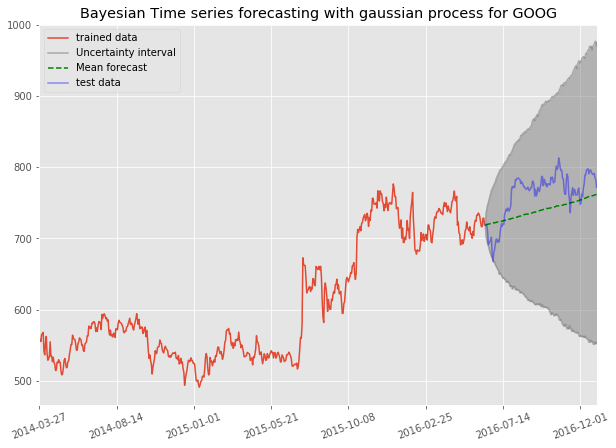

In [30]:
test_set_plot_arr = np.empty(df_goog.shape[0])
test_set_plot_arr[:] = np.nan
test_set_plot_arr[-len(test):] = test.values
labels = [item for item in df_goog.index]
indexes = []

fig, ax = plt.subplots(figsize=(10,7))
empty_arr_bis = np.empty((train.values.shape[0],))
empty_arr_bis[:] = np.nan
empty_arr = np.empty((low.shape[0],))
empty_arr[:] = np.nan

train_arr = np.r_[train.values,empty_arr]
ax.plot(train_arr,label="trained data")
ax.plot(np.r_[empty_arr_bis, low + train.values[-1]],c="grey", label="Uncertainty interval", alpha=0.6)
ax.plot(np.r_[empty_arr_bis, high + train.values[-1]], c="grey", alpha=0.6)
ax.fill_between(np.linspace(train.shape[0], train.shape[0] + test.shape[0], test.shape[0]), high + train.values[-1], low + train.values[-1], color="grey", alpha=0.5)
ax.plot(np.r_[empty_arr_bis, ppc_test['z'].mean(axis=0) + train.values[-1]],label="Mean forecast", c='green', ls='--')
ax.plot(test_set_plot_arr,label="test data",alpha=0.4,c="b")

ax.set_xticks(np.arange(0, len(df_goog), 100))
ax.set_xticklabels(df_goog.index[::100], rotation=20)
ax.set_xlim(0,len(df_goog))
plt.legend()
plt.title("Bayesian Time series forecasting with gaussian process for GOOG")
ax = plt.gca()
plt.show()